In [1]:
# set the environment variable for warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# enable autoreload
%load_ext autoreload
%autoreload 2

# basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#tensorflow
import tensorflow as tf
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout

import tensorflow_probability as tfp
tfd = tfp.distributions

# others
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from copy import deepcopy
import sherpa
from xgboost import XGBRegressor
import sys
import time
from scipy.stats import gamma, norm, beta

# Variables from config file
sys.path.append('/home/yusukemh/github/yusukemh/StatisticalDownscaling/codes/')
from config import BASE_DIR, FILE_NAMES, LABELS, ATTRIBUTES, BEST_MODEL_COLUMNS, ISLAND_RANGES, C_SINGLE, C_INT50, C_INT100, C_GRID, C_COMMON

# util
from util import cross_val_predict_for_nn, sample_station, estimate_epochs, define_model, define_hetero_model_normal, define_hetero_model_gamma

2022-06-04 01:10:56.157846: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/apps/software/tools/nmap/7.80/lib


In [2]:
def define_model(
    input_dim=20, 
    lr=0.005, 
    activation='relu',
    n_units=1024,
    n_layers=2,
    dropout=0.5
):
    inputs = Input(shape=(input_dim,))
    x = Dense(units=n_units, activation=activation)(inputs)
    
    for i in range(n_layers - 1):
        if dropout:
            x = Dropout(rate=dropout)(x)
        x = Dense(units=n_units, activation=activation)(x)
    outputs = Dense(units=1, kernel_initializer=tf.keras.initializers.HeNormal, activation='softplus')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=lr),
        loss='mse',
        metrics=[RootMeanSquaredError()]
    )
    
    return model

def define_hetero_model_gamma(
    input_dim=20, lr=0.0065,
    n_additional_layers_main=4,
    n_additional_layers_sub=2,
    activation='elu',
    n_units_main=512,
    n_units_sub=256,
    dropout=0.5,
):
    inputs = Input(shape=(input_dim,))
    x = Dense(
        units=n_units_main, activation=activation, kernel_initializer=tf.keras.initializers.HeNormal,
        kernel_regularizer='l1'
    )(inputs)
    
    for _ in range(n_additional_layers_main):
        x = Dense(units=n_units_main, activation=activation, kernel_initializer=tf.keras.initializers.HeNormal, kernel_regularizer='l1')(x)
        if dropout:
            x = Dropout(rate=0.5)(x)
    
    m = Dense(units=n_units_sub, activation=activation, kernel_initializer=tf.keras.initializers.HeNormal, kernel_regularizer='l1')(x)
    for _ in range(n_additional_layers_sub):
        m = Dense(units=n_units_sub, activation=activation, kernel_initializer=tf.keras.initializers.HeNormal, kernel_regularizer='l1')(m)
    m = Dense(units=10, activation=activation, kernel_initializer=tf.keras.initializers.HeNormal, kernel_regularizer='l1')(m)
    m = Dense(units=1, activation='linear', kernel_initializer=tf.keras.initializers.HeNormal, kernel_regularizer='l1')(m)
    
    s = Dense(units=n_units_sub, activation=activation, kernel_initializer=tf.keras.initializers.HeNormal, kernel_regularizer='l1')(x)
    for _ in range(n_additional_layers_sub):
        s = Dense(units=n_units_sub, activation=activation, kernel_initializer=tf.keras.initializers.HeNormal, kernel_regularizer='l1')(s)
    s = Dense(units=10, activation=activation, kernel_initializer=tf.keras.initializers.HeNormal, kernel_regularizer='l1')(s)
    s = Dense(units=1, activation='linear', kernel_initializer=tf.keras.initializers.HeNormal, kernel_regularizer='l1')(s)
    
    ms = Concatenate(axis=-1)([m, s])
    outputs = tfp.layers.DistributionLambda(
        make_distribution_fn=lambda t: tfd.Gamma(
            concentration=tf.math.softplus(t[...,0]), rate=tf.math.softplus(t[...,1])
        ),
        convert_to_tensor_fn=lambda d: d.mean()
    )(ms)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    epsilon=1e-5 # for loss function
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=lr),
        loss=lambda y, p_y: -p_y.log_prob(y + epsilon),
        # loss=safe_nll,
        metrics=[RootMeanSquaredError()]
    )
    
    return model


@tf.autograph.experimental.do_not_convert
def define_hetero_model_normal(
    input_dim, lr=0.0065,
    n_additional_layers_main=0,
    n_additional_layers_sub=0,
    activation='relu',
    n_units_main=512,
    n_units_sub=10,
    dropout=0.5,
    l2_sigma=100,
    sigma_a=0.001,# these hyperparameters might have significant affect
    sigma_b=0.03 # these hyperparameters might have signigicant affect
):
    inputs = Input(shape=(input_dim,))
    x = Dense(units=n_units_main, activation=activation, kernel_initializer=tf.keras.initializers.HeNormal)(inputs)
    # main branch
    for _ in range(n_additional_layers_main):
        if dropout:
            x = Dropout(rate=dropout)(x)
        x = Dense(units=n_units_main, activation=activation, kernel_initializer=tf.keras.initializers.HeNormal)(x)
    # mean branch
    if n_additional_layers_sub == 0:
        m = Dense(units=1, activation='linear', kernel_initializer=tf.keras.initializers.HeNormal)(x)
    else:
        m = Dense(units=n_units_sub, activation=activation, kernel_initializer=tf.keras.initializers.HeNormal)(x)
        for _ in range(n_additional_layers_sub - 1):
            m = Dense(units=n_units_sub, activation=activation)(m)
        m = Dense(units=1, activation='linear', kernel_initializer=tf.keras.initializers.HeNormal)(m)
    
    # std branch
    if n_additional_layers_sub == 0:
        s = Dense(units=1, activation='linear', kernel_initializer=tf.keras.initializers.HeNormal, kernel_regularizer=tf.keras.regularizers.L2(l2=l2_sigma))(x)
    else:
        s = Dense(units=n_units_sub, activation=activation, kernel_initializer=tf.keras.initializers.HeNormal)(x)
        for _ in range(n_additional_layers_sub - 1):
            s = Dense(units=n_units_sub, activation=activation)(s)
        s = Dense(units=1, activation='linear', kernel_initializer=tf.keras.initializers.HeNormal, kernel_regularizer=tf.keras.regularizers.L2(l2=l2_sigma))(s)
    
    ms = Concatenate(axis=-1)([m, s])
    outputs = tfp.layers.DistributionLambda(
        make_distribution_fn=lambda t: tfd.Normal(
            loc=t[...,0], scale=tf.math.softplus(sigma_a * t[...,1] + sigma_b)
        ),
        convert_to_tensor_fn=lambda s: s.mean()
    )(ms)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=lr),
        # loss=lambda y, p_y: -p_y.log_prob(y),
        loss=lambda y, p_y: -p_y.log_prob(y + 1e-5),
        metrics=[RootMeanSquaredError()]
    )
    
    return model

In [3]:
df_nonfilled = pd.read_csv(f"{BASE_DIR}/nonfilled_dataset.csv", usecols=C_SINGLE + C_COMMON)

df_n_data = df_nonfilled.groupby('skn').size().reset_index().rename(columns={0: "n_data"})
df_n_data = df_n_data[df_n_data['n_data'] > 750]
df_filtered = df_nonfilled.merge(df_n_data, left_on='skn', right_on='skn', how='inner')

In [4]:
n_folds = 5

df_len_by_month = pd.DataFrame(df_filtered.groupby(by=["year", "month"]).size()).reset_index().rename({0:"len"}, axis=1)
df_len_by_month['cumsum'] = df_len_by_month['len'].cumsum()

n_samples_total = df_len_by_month['cumsum'].iloc[-1]
n_samples_per_fold = np.ceil(n_samples_total / n_folds)

df_len_by_month['fold'] = df_len_by_month.apply(lambda row: int(row['cumsum'] / n_samples_per_fold), axis=1)

print("The numbers of examples in each fold")
for fold in range(5):
    print(df_len_by_month[df_len_by_month['fold'] == fold]['len'].sum())
    
df_filtered = pd.merge(left=df_filtered, right=df_len_by_month, left_on=["year", "month"], right_on=["year", "month"])

The numbers of examples in each fold
3673
3703
3686
3700
3709


In [94]:
i = 1
df_train = df_filtered[df_filtered['fold'] != i]
df_test = df_filtered[df_filtered['fold'] == i]

skn = 54
columns = C_SINGLE

Xtrain, Xtest = np.array(df_train[columns]), np.array(df_test[columns])
scaler = MinMaxScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

Ytrain, Ytest = np.array(df_train['data_in']), np.array(df_test['data_in'])

Xtrain_station = np.array(df_train[df_train['skn'] == skn][columns])
Ytrain_station = np.array(df_train[df_train['skn'] == skn]['data_in'])

Xtest_station = np.array(df_test[df_test['skn'] == skn][columns])
Ytest_station = np.array(df_test[df_test['skn'] == skn]['data_in'])

Xtrain_station = scaler.transform(Xtrain_station)
Xtest_station = scaler.transform(Xtest_station)

# model_nn = define_hetero_model_normal(input_dim=len(columns), n_additional_layers_main=0, n_additional_layers_sub=0, n_units_main=216)
model_nn = define_model(
    input_dim=len(columns), 
    lr=0.0001,
    activation='elu',
    n_units=216,
    n_layers=0,
    dropout=0.5
)
model_nn.fit(Xtrain, Ytrain, epochs=50, verbose=False)

# intermediate performance
# yhat_all = model_nn.predict(Xtest)
# mean_squared_error(Ytest, yhat_all, squared=False)


# model_nn.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001))
model_nn.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.002),
    loss='mse',
    metrics=[RootMeanSquaredError()]
)
model_nn.fit(Xtrain_station, Ytrain_station, epochs=100, verbose=False)
yhat_station = model_nn.predict(Xtest_station)
rmse_nn = mean_squared_error(Ytest_station, yhat_station, squared=False)

# Linear Regression
linear_regression = LinearRegression()
linear_regression.fit(Xtrain_station, Ytrain_station)
yhat_linear_regression = linear_regression.predict(Xtest_station)
rmse_lr = mean_squared_error(Ytest_station, yhat_linear_regression, squared=False)

print('Fold {}\n LR: {:.10f}, NN: {:.10f}'.format(i, rmse_lr, rmse_nn))

Fold 1
 LR: 4.6922621210, NN: 4.6310030294


In [5]:
def cross_val_predict(skn, df_nonfilled):

    yhat_nn = []
    yhat_lr = []
    ytrue = []
    skn = 396
    columns = C_SINGLE

    for i in range(n_folds):
        df_train = df_filtered[df_filtered['fold'] != i]
        df_test = df_filtered[df_filtered['fold'] == i]

        Xtrain, Xtest = np.array(df_train[columns]), np.array(df_test[columns])
        scaler = MinMaxScaler()
        Xtrain = scaler.fit_transform(Xtrain)
        Xtest = scaler.transform(Xtest)

        Ytrain, Ytest = np.array(df_train['data_in']), np.array(df_test['data_in'])

        Xtrain_station = np.array(df_train[df_train['skn'] == skn][columns])
        Ytrain_station = np.array(df_train[df_train['skn'] == skn]['data_in'])

        Xtest_station = np.array(df_test[df_test['skn'] == skn][columns])
        Ytest_station = np.array(df_test[df_test['skn'] == skn]['data_in'])

        Xtrain_station = scaler.transform(Xtrain_station)
        Xtest_station = scaler.transform(Xtest_station)

        # model_nn = define_hetero_model_normal(input_dim=len(columns), n_additional_layers_main=0, n_additional_layers_sub=0, n_units_main=216)
        model_nn = define_model(
            input_dim=len(columns), 
            lr=0.0001,
            activation='elu',
            n_units=216,
            n_layers=0,
            dropout=0.5
        )
        model_nn.fit(Xtrain, Ytrain, epochs=50, verbose=False)

        # intermediate performance
        # yhat_all = model_nn.predict(Xtest)
        # mean_squared_error(Ytest, yhat_all, squared=False)

        model_nn.compile(
            optimizer=tf.optimizers.Adam(learning_rate=0.002),
            loss='mse',
            metrics=[RootMeanSquaredError()]
        )

        model_nn.fit(Xtrain_station, Ytrain_station, epochs=100, verbose=False)
        yhat_station = model_nn.predict(Xtest_station)
        rmse_nn = mean_squared_error(Ytest_station, yhat_station, squared=False)

        # Linear Regression
        linear_regression = LinearRegression()
        linear_regression.fit(Xtrain_station, Ytrain_station)
        yhat_linear_regression = linear_regression.predict(Xtest_station)
        rmse_lr = mean_squared_error(Ytest_station, yhat_linear_regression, squared=False)

        print('Fold {}\n LR: {:.10f}, NN: {:.10f}'.format(i, rmse_lr, rmse_nn))
        ytrue.extend(Ytest_station)
        yhat_lr.extend(yhat_linear_regression)
        yhat_nn.extend(yhat_station)

    

2022-06-04 01:11:34.152913: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/apps/software/tools/nmap/7.80/lib
2022-06-04 01:11:34.160131: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/apps/software/tools/nmap/7.80/lib
2022-06-04 01:11:34.160241: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/apps/software/tools/nmap/7.80/lib
2022-06-04 01:11:34.160331: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerr

Fold 0
 LR: 1.5124840054, NN: 1.4525402796
Fold 1
 LR: 1.4605165501, NN: 1.4162174993
Fold 2
 LR: 1.5172626810, NN: 1.4908868199
Fold 3
 LR: 1.7978279276, NN: 1.8255521192
Fold 4
 LR: 1.3619483611, NN: 1.1733404171


In [6]:
mean_squared_error(ytrue, yhat_nn, squared=False), mean_squared_error(ytrue, yhat_lr, squared=False)

(1.4860517675118443, 1.5366046591631417)

In [104]:
df_nonfilled[df_nonfilled['skn'] == 396]['lat'].iloc[0], df_nonfilled[df_nonfilled['skn'] == 396]['lon'].iloc[0]

(20.871792703, -156.453846576)

In [69]:
yhat_nn = []
yhat_lr = []
ytrue = []

for i in range(n_folds):
    df_train = df_filtered[df_filtered['fold'] != i]
    df_test = df_filtered[df_filtered['fold'] == i]
    
    skn = 396
    columns = C_SINGLE

    Xtrain, Xtest = np.array(df_train[columns]), np.array(df_test[columns])
    scaler = MinMaxScaler()
    Xtrain = scaler.fit_transform(Xtrain)
    Xtest = scaler.transform(Xtest)

    Ytrain, Ytest = np.array(df_train['data_in']), np.array(df_test['data_in'])

    Xtrain_station = np.array(df_train[df_train['skn'] == skn][columns])
    Ytrain_station = np.array(df_train[df_train['skn'] == skn]['data_in'])

    Xtest_station = np.array(df_test[df_test['skn'] == skn][columns])
    Ytest_station = np.array(df_test[df_test['skn'] == skn]['data_in'])

    Xtrain_station = scaler.transform(Xtrain_station)
    Xtest_station = scaler.transform(Xtest_station)
    
    # model_nn = define_hetero_model_normal(input_dim=len(columns), n_additional_layers_main=0, n_additional_layers_sub=0, n_units_main=216)
    model_nn = define_model(input_dim=len(columns), n_layers=0, n_units=216)
    model_nn.fit(Xtrain, Ytrain, epochs=50, verbose=False)
    
    # intermediate performance
    # yhat_all = model_nn.predict(Xtest)
    # mean_squared_error(Ytest, yhat_all, squared=False)
    
    model_nn.fit(Xtrain_station, Ytrain_station, epochs=100, verbose=False)
    yhat_station = model_nn.predict(Xtest_station)
    rmse_nn = mean_squared_error(Ytest_station, yhat_station, squared=False)
    
    # Linear Regression
    linear_regression = LinearRegression()
    linear_regression.fit(Xtrain_station, Ytrain_station)
    yhat_linear_regression = linear_regression.predict(Xtest_station)
    rmse_lr = mean_squared_error(Ytest_station, yhat_linear_regression, squared=False)
    
    print('Fold {}\n LR: {:.10f}, NN: {:.10f}'.format(i, rmse_lr, rmse_nn))
    ytrue.extend(Ytest_station)
    yhat_lr.extend(yhat_linear_regression)
    yhat_nn.extend(yhat_station)
    
    

Fold 0
 LR: 1.5124840054, NN: 1.4521954782
Fold 1
 LR: 1.4605165501, NN: 1.5045156674
Fold 2
 LR: 1.5172626810, NN: 1.4462081891
Fold 3
 LR: 1.7978279276, NN: 1.7222471623
Fold 4
 LR: 1.3619483611, NN: 1.3469790759


In [70]:
mean_squared_error(ytrue, yhat_nn, squared=False), mean_squared_error(ytrue, yhat_lr, squared=False)

(1.4993159280271473, 1.5366046591631417)

# Linear Regression

In [17]:
columns = C_SINGLE

# load datasets
df_train = pd.read_csv(f"{BASE_DIR}/train.csv", usecols=columns + ['year', 'month', 'skn', 'data_in'])
df_valid = pd.read_csv(f"{BASE_DIR}/valid.csv", usecols=columns + ['year', 'month', 'skn', 'data_in'])
df_test = pd.read_csv(f"{BASE_DIR}/test.csv", usecols=columns + ['year', 'month', 'skn', 'data_in'])


df_combined = pd.concat([df_train, df_valid, df_test])

df_valid_skn = df_combined.groupby('skn').size().reset_index().rename(columns={0: "n_data"})
df_valid_skn = df_valid_skn[df_valid_skn['n_data'] > 750]

df_train = df_train.merge(df_valid_skn, left_on='skn', right_on='skn', how='inner')
df_valid = df_valid.merge(df_valid_skn, left_on='skn', right_on='skn', how='inner')
df_test = df_test.merge(df_valid_skn, left_on='skn', right_on='skn', how='inner')

df_train = pd.concat([df_train, df_valid])

In [36]:
ytrue = []
yhat = []
for name, group in pd.concat([df_train, df_test]).groupby(by='skn'):
    group.sort_values(['year', 'month'])
    X = np.array(group[columns])
    Y = np.array(group['data_in'])
    
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, shuffle=False)
    linear_regression = LinearRegression()
    linear_regression.fit(Xtrain, Ytrain)
    ytrue.extend(Ytest)
    yhat.extend(linear_regression.predict(Xtest))

rmse = mean_squared_error(ytrue, yhat, squared=False)
print("{:.2f}".format(rmse))

4.44


In [37]:
Xtrain = np.array(df_train[columns])
Xtest = np.array(df_test[columns])

Ytrain = np.array(df_train['data_in'])
Ytest = np.array(df_test['data_in'])

scaler = MinMaxScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.fit_transform(Xtest)

In [30]:
model_nn = define_hetero_model_normal(input_dim=len(columns), n_additional_layers_main=0, n_additional_layers_sub=0, n_units_main=216)
model_nn.fit(Xtrain, Ytrain, epochs=50)

Epoch 1/50
4929/4929 [==============================] - 6s 1ms/step - loss: 48.9633 - root_mean_squared_error: 6.9923
Epoch 2/50
4929/4929 [==============================] - 5s 1ms/step - loss: 42.6200 - root_mean_squared_error: 6.6472
Epoch 3/50
4929/4929 [==============================] - 5s 1ms/step - loss: 38.6071 - root_mean_squared_error: 6.4245
Epoch 4/50
4929/4929 [==============================] - 5s 1ms/step - loss: 36.1352 - root_mean_squared_error: 6.3102
Epoch 5/50
4929/4929 [==============================] - 5s 1ms/step - loss: 33.9483 - root_mean_squared_error: 6.2117
Epoch 6/50
4929/4929 [==============================] - 6s 1ms/step - loss: 31.9191 - root_mean_squared_error: 6.1156
Epoch 7/50
4929/4929 [==============================] - 6s 1ms/step - loss: 30.0986 - root_mean_squared_error: 6.0288
Epoch 8/50
4929/4929 [==============================] - 6s 1ms/step - loss: 28.6151 - root_mean_squared_error: 5.9666
Epoch 9/50
4929/4929 [==============================] - 

In [38]:
yhat_all = model_nn.predict(Xtest)
mean_squared_error(Ytest, yhat_all, squared=False)

7.223660901765741

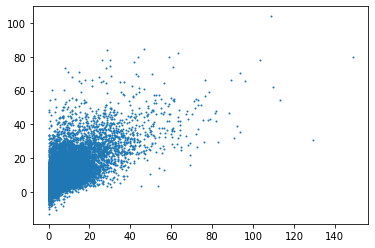

In [40]:
fig, ax = plt.subplots(1)
ax.scatter(Ytest, yhat_all, s=1)

In [45]:
skn = 396
Xtrain_station = np.array(df_train[df_train['skn'] == skn][columns])
Xtest_station = np.array(df_test[df_test['skn'] == skn][columns])

Ytrain_station = np.array(df_train[df_train['skn'] == skn]['data_in'])
Ytest_station = np.array(df_test[df_test['skn'] == skn]['data_in'])

Xtrain_station = scaler.fit_transform(Xtrain_station)
Xtest_station = scaler.transform(Xtest_station)

In [52]:
model_nn.fit(Xtrain_station, Ytrain_station, epochs=30)

Epoch 1/30
34/34 [==============================] - 0s 1ms/step - loss: 1.7544 - root_mean_squared_error: 1.3971
Epoch 2/30
34/34 [==============================] - 0s 1ms/step - loss: 1.7518 - root_mean_squared_error: 1.3929
Epoch 3/30
34/34 [==============================] - 0s 1ms/step - loss: 1.7724 - root_mean_squared_error: 1.4231
Epoch 4/30
34/34 [==============================] - 0s 1ms/step - loss: 1.7903 - root_mean_squared_error: 1.4488
Epoch 5/30
34/34 [==============================] - 0s 1ms/step - loss: 1.7711 - root_mean_squared_error: 1.4215
Epoch 6/30
34/34 [==============================] - 0s 1ms/step - loss: 1.7499 - root_mean_squared_error: 1.3905
Epoch 7/30
34/34 [==============================] - 0s 1ms/step - loss: 1.7493 - root_mean_squared_error: 1.3895
Epoch 8/30
34/34 [==============================] - 0s 1ms/step - loss: 1.7443 - root_mean_squared_error: 1.3820
Epoch 9/30
34/34 [==============================] - 0s 1ms/step - loss: 1.7624 - root_mean_squar

In [53]:
yhat_station = model_nn.predict(Xtest_station)
mean_squared_error(Ytest_station, yhat_station)

1.8465228677078218

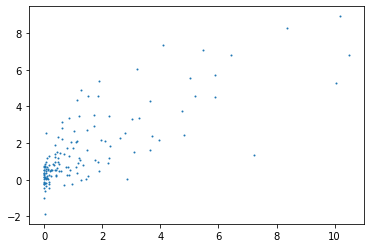

In [55]:
fig, ax = plt.subplots(1)
ax.scatter(Ytest_station, yhat_station, s=1)